# Arm Motion Modeling

## System Description

A double-pendulum system hanging in gravity is shown in the figure above. $q=[\theta_1, \theta_2]$ are the system configuration variables. We assume the z-axis is pointing out from the screen/paper, thus the positive direction of rotation is counter-clockwise.
The solution steps are:
1. Computing the Lagrangian of the system. 
2. Computing the Euler-Lagrange equations, and solve them for $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
3. Numerically evaluating the solutions for ${\tau}_1$ and ${\tau}_2$, and simulating the system for ${\theta}_1$, ${\theta}_2$, $\dot{\theta}_1$, $\dot{\theta}_2$, $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
4. Animating the simulation.

In [2]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='./double-pendulum-diagram.png' width=450' height='300'></table>"))

## Import Libraries and Define System Constants

Import libraries:

In [3]:
# Imports required for data processing
import os
import csv
import pandas as pd

# Imports required for dynamics calculations
import sympy
from sympy.abc import t
from sympy import symbols, Eq, Function, solve, sin, cos, Matrix, Subs, substitution, Derivative, simplify, symbols, lambdify
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Imports required for animation
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import plotly.graph_objects as go

Parameters:

In [18]:
use_my_data = True
use_double_pendulum = True

Define the system's constants:

In [5]:
if use_my_data:
    # Masses, length and center-of-mass positions (calculated using the lab measurements)
    # Mass calculations (mass unit is kg) 
    m_body = 53
    m_u = 0.028 * m_body                     # Average upper arm weights relative to body weight, from “Biomechanics
                                             # and Motor Control of Human Movement” by David Winter (2009), 4th edition
    m_l = 0.7395                             # Average lower prosthetics weights, calculated using lab measurements  
    # m_lower = 0.022 * m_body               # Average lower arm weights relative to body weight, from “Biomechanics
                                             # and Motor Control of Human Movement” by David Winter (2009), 4th edition
    # Arm length calculations (length unit is m) 
    H_body = 1.62
    L_u = 0.186 * H_body                     # Average upper arm length relative to body height
                                             # from “Biomechanics and Motor Control of Human Movement” by David
                                             # Winter (2009), 4th edition
    # L_l = (0.146 + 0.108) * H_body         # Average lower arm length relative to body height
                                             # from “Biomechanics and Motor Control of Human Movement” by David
                                             # Winter (2009), 4th edition
    L_l = 0.42                               # Average lower prosthetics length, calculated using lab measurements 

    # Arm center of mass length calculations (length unit is m) 
    L_u_c = 0.436 * L_u                      # Average upper arm length from shoulder to center of mass relative
                                             # to upper arm length, from “Biomechanics and Motor Control of Human
                                             # Movement” by David Winter (2009), 4th edition
    L_l_c = 0.2388                           # Average lower prosthetics length from elbow to center of mass,
                                             # calculated using lab measurements 
    # L_l_c = 0.682 * L_l                    # Average lower arm length from shoulder to center of mass relative
                                             # to upper arm length, from “Biomechanics and Motor Control of Human
                                             # Movement” by David Winter (2009), 4th edition
else:
    # Masses, length and center-of-mass positions (calculated using the lab measurements)
    # Mass calculations (mass unit is kg) 
    m_body = 90.6                            # Average weights for American adult male
                                             # from "Anthropometric Reference Data for Children and Adults:
                                             # United States, 2015–2018"
    m_body_dict = {'ID': 51.0, 'JD': 79.5, 'JR': 76.0, 'KS': 59.3, 'KW': 63.8, 'LC': 61.2,
                   'LD': 97.3, 'LS': 82.2, 'MK': 93.5, 'MV': 98.5, 'SM': 68.5, 'TD': 70.0,
                   'TM': 66.2}

    m_u = 0.028 * m_body                     # Average upper arm weights relative to body weight, from “Biomechanics
                                             # and Motor Control of Human Movement” by David Winter (2009), 4th edition
    m_u_dict = {'ID': 0.028 * m_body_dict['ID'], 'JD': 0.028 * m_body_dict['JD'],
                'JR': 0.028 * m_body_dict['JR'], 'KS': 0.028 * m_body_dict['KS'],
                'KW': 0.028 * m_body_dict['KW'], 'LC': 0.028 * m_body_dict['LC'],
                'LD': 0.028 * m_body_dict['LD'], 'LS': 0.028 * m_body_dict['LS'],
                'MK': 0.028 * m_body_dict['MK'], 'MV': 0.028 * m_body_dict['MV'],
                'SM': 0.028 * m_body_dict['SM'], 'TD': 0.028 * m_body_dict['TD'],
                'TM': 0.028 * m_body_dict['TM']}

    m_l = 0.7395                             # Average lower prosthetics weights, calculated using lab measurements  

    # Arm length calculations (length unit is m) 
    H_body = 1.769                           # Average height for American adult male, from “Height and body-mass 
                                             # index trajectories of school-aged children and adolescents from 
                                             # 1985 to 2019 in 200 countries and territories: a pooled analysis 
                                             # of 2181 population-based studies with 65 million participants”
    H_body_dict = {'ID': 1.620, 'JD': 1.760, 'JR': 1.770, 'KS': 1.640, 'KW': 1.620, 'LC': 1.580,
                   'LD': 1.875, 'LS': 1.635, 'MK': 1.780, 'MV': 1.805, 'SM': 1.790, 'TD': 1.690,
                   'TM': 1.735}

    L_u = 0.186 * H_body                     # Average upper arm length relative to body height
                                             # from “Biomechanics and Motor Control of Human Movement” by David
                                             # Winter (2009), 4th edition
    L_u_dict = {'ID': 0.186 * H_body_dict['ID'], 'JD': 0.186 * H_body_dict['JD'],
                'JR': 0.186 * H_body_dict['JR'], 'KS': 0.186 * H_body_dict['KS'],
                'KW': 0.186 * H_body_dict['KW'], 'LC': 0.186 * H_body_dict['LC'],
                'LD': 0.186 * H_body_dict['LD'], 'LS': 0.186 * H_body_dict['LS'],
                'MK': 0.186 * H_body_dict['MK'], 'MV': 0.186 * H_body_dict['MV'],
                'SM': 0.186 * H_body_dict['SM'], 'TD': 0.186 * H_body_dict['TD'],
                'TM': 0.186 * H_body_dict['TM']}

    L_l = 0.42                               # Average lower prosthetics length, calculated using lab measurements

    # Arm center of mass length calculations (length unit is m) 
    L_u_c = 0.436 * L_u                      # Average upper arm length from shoulder to center of mass relative
                                             # to upper arm length, from “Biomechanics and Motor Control of Human
                                             # Movement” by David Winter (2009), 4th edition
    L_u_c_dict = {'ID': 0.436 * L_u_dict['ID'], 'JD': 0.436 * L_u_dict['JD'],
                  'JR': 0.436 * L_u_dict['JR'], 'KS': 0.436 * L_u_dict['KS'],
                  'KW': 0.436 * L_u_dict['KW'], 'LC': 0.436 * L_u_dict['LC'],
                  'LD': 0.436 * L_u_dict['LD'], 'LS': 0.436 * L_u_dict['LS'],
                  'MK': 0.436 * L_u_dict['MK'], 'MV': 0.436 * L_u_dict['MV'],
                  'SM': 0.436 * L_u_dict['SM'], 'TD': 0.436 * L_u_dict['TD'],
                  'TM': 0.436 * L_u_dict['TM']}
    L_l_c = 0.2388                           # Average lower prosthetics length from elbow to center of mass,
                                             # calculated using lab measurements 

## Extracting Data

Extracting angles data and computing angular velocities and angular accelerations from the angles:

In [128]:
def calculate_vel(ang_list, time_list, index):
    return ((ang_list[index + 1] - ang_list[index])
          / (time_list[index + 1] - time_list[index]))


def calculate_acc(vel_list, time_list, index):
    return ((vel_list[index + 1] - vel_list[index])
          / (time_list[index + 1] - time_list[index]))


data_csv_dir = '../../data/hand_back_motion_data/CSV Converted Files'
print("current directory: ", os.getcwd())

if use_my_data:
    frame_frequency = 100

    walking_vel_list = []
    time_list = []
    elbow_ang_list, shoulder_ang_list, tot_ang_list = [], [], []
    elbow_vel_list, shoulder_vel_list = [], []
    elbow_acc_list, shoulder_acc_list = [], []
    elbow_acc_data_list, shoulder_acc_data_list = [], []
    back_ang_list, back_pos_list, back_vel_list = [], [], []

    folder_list = os.listdir(data_csv_dir)
    folder_list.sort()

    for folder in folder_list:

        data_trial_dir = os.path.join(data_csv_dir, folder)
        if os.path.isdir(data_trial_dir):
            file_list = os.listdir(data_trial_dir)

            for file in file_list:
                if "00B429F8" in file:
                    if file.endswith(".csv"):
                        file_name = file[:-4]
                        walking_vel = file.split("_")[4][:5]

                        frame = 0
                        file_time_list = []
                        file_shoulder_ang_list, file_shoulder_vel_list, file_shoulder_acc_list, file_shoulder_acc_data_list = [], [], [], []

                        # Cutting out weird data behavior on data edges
                        data_path = os.path.join(data_csv_dir, folder, file)
                        data_rows = open(data_path).read().strip().split("\n")[6000:7500]

                        # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
                        for row in data_rows:
                            splitted_row = row.strip().split("\t")

                            # Check if loop finished all data
                            if not len(splitted_row):
                                break

                            file_time_list.append(frame / frame_frequency)
                            file_shoulder_ang_list.append(float(splitted_row[31]) * 2*pi/360)
                            file_shoulder_acc_data_list.append(float(splitted_row[14]))
                            frame += 1

                        # Extract elbow and shoulder velocities [rad/sec] from angles
                        for i in range(len(file_time_list) - 1):
                            shoulder_vel = calculate_vel(file_shoulder_ang_list, file_time_list, i)
                            file_shoulder_vel_list.append(shoulder_vel)

                        # Extract elbow and shoulder Accelerations [rad/sec^2] from velocities
                        for i in range(len(file_time_list) - 2):
                            shoulder_acc = calculate_acc(file_shoulder_vel_list, file_time_list, i)
                            file_shoulder_acc_list.append(shoulder_acc)

                        # Adjust lists length
                        adjusted_file_time_list = file_time_list[:-2]
                        adjusted_file_shoulder_ang_list = file_shoulder_ang_list[:-2]
                        adjusted_file_shoulder_vel_list = file_shoulder_vel_list[:-1]
                        adjusted_file_shoulder_acc_data_list = file_shoulder_acc_data_list[:-2]

                        time_list.append(adjusted_file_time_list)
                        walking_vel_list.append(walking_vel)

                        shoulder_ang_list.append(adjusted_file_shoulder_ang_list)
                        shoulder_vel_list.append(adjusted_file_shoulder_vel_list)
                        shoulder_acc_list.append(file_shoulder_acc_list)
                        shoulder_acc_data_list.append(adjusted_file_shoulder_acc_data_list)
                        break

            for file in file_list:
                if "00B429E2" in file:
                    if file.endswith(".csv"):
                        file_name = file[:-4]
                        walking_vel = file.split("_")[4][:5]

                        frame = 0
                        file_time_list = []
                        file_elbow_ang_list, file_tot_ang_list, file_elbow_vel_list, file_elbow_acc_list, file_elbow_acc_data_list = [], [], [], [], []

                        # Cutting out weird data behavior on data edges
                        data_path = os.path.join(data_csv_dir, folder, file)
                        data_rows = open(data_path).read().strip().split("\n")[6000:7500]

                        # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
                        for i in range(len(data_rows)):
                            splitted_row = data_rows[i].strip().split("\t")

                            # Check if loop finished all data
                            if not len(splitted_row):
                                break

                            file_time_list.append(frame / frame_frequency)
                            file_tot_ang_list.append(float(splitted_row[31]) * 2*pi/360)
                            file_elbow_ang_list.append((float(splitted_row[31]) - file_shoulder_ang_list[i]) * 2*pi/360)
                            file_elbow_acc_data_list.append(float(splitted_row[14]))
                            frame += 1

                        # Extract elbow and shoulder velocities [rad/sec] from angles
                        for i in range(len(file_time_list) - 1):
                            elbow_vel = calculate_vel(file_elbow_ang_list, file_time_list, i)
                            file_elbow_vel_list.append(elbow_vel)

                        # Extract elbow and shoulder Accelerations [rad/sec^2] from velocities
                        for i in range(len(file_time_list) - 2):
                            elbow_acc = calculate_acc(file_elbow_vel_list, file_time_list, i)
                            file_elbow_acc_list.append(elbow_acc)

                        # Adjust lists length
                        adjusted_file_tot_ang_list = file_tot_ang_list[:-2]
                        adjusted_file_elbow_ang_list = file_elbow_ang_list[:-2]
                        adjusted_file_elbow_vel_list = file_elbow_vel_list[:-1]
                        adjusted_file_elbow_acc_data_list = file_elbow_acc_data_list[:-2]

                        tot_ang_list.append(adjusted_file_tot_ang_list)
                        elbow_ang_list.append(adjusted_file_elbow_ang_list)
                        elbow_vel_list.append(adjusted_file_elbow_vel_list)
                        elbow_acc_list.append(file_elbow_acc_list)
                        elbow_acc_data_list.append(file_elbow_acc_data_list)
                        break

            for file in file_list:
                if "00B43D0C" in file:
                    if file.endswith(".csv"):
                        file_name = file[:-4]
                        walking_vel = file.split("_")[4][:5]
                        if walking_vel == "1.4ms":
                            continue

                        frame = 0
                        file_time_list = []
                        file_back_ang_list, file_back_pos_list, file_back_vel_list = [], [], []

                        # Cutting out weird data behavior on data edges
                        data_path = os.path.join(data_csv_dir, folder, file)
                        data_rows = open(data_path).read().strip().split("\n")[6000:7500]

                        # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
                        for i in range(len(data_rows)):
                            splitted_row = data_rows[i].strip().split("\t")

                            # Check if loop finished all data
                            if not len(splitted_row):
                                break

                            file_time_list.append(frame / frame_frequency)

                            file_back_ang_list.append(float(splitted_row[31]) * 2*pi/360)
                            file_back_pos_list.append(float(splitted_row[21]))
                            file_back_vel_list.append(float(splitted_row[24]))
                            frame += 1

                        # Adjust lists length
                        adjusted_file_back_ang_list = file_back_ang_list[:-2]
                        adjusted_file_back_pos_list = file_back_pos_list[:-2]
                        adjusted_file_back_vel_list = file_back_vel_list[:-2]

                        back_ang_list.append(adjusted_file_back_ang_list)
                        back_pos_list.append(adjusted_file_back_pos_list)
                        back_vel_list.append(adjusted_file_back_vel_list)
                        break

else:
    frame_frequency = 120

    participants_list = []
    time_list = []
    elbow_ang_list, shoulder_ang_list = [], []
    elbow_vel_list, shoulder_vel_list = [], []
    elbow_acc_list, shoulder_acc_list = [], []

    for file in os.listdir(data_csv_dir):
        file_name = file.split(".")[0]
        participant_name = file.split("_")[0]

        if file.endswith(".csv"):
            frame = 0
            file_time_list = []
            file_R_elbow_ang_list, file_R_shoulder_ang_list = [], []
            file_L_elbow_ang_list, file_L_shoulder_ang_list = [], []
            file_R_elbow_vel_list, file_R_shoulder_vel_list = [], []
            file_L_elbow_vel_list, file_L_shoulder_vel_list = [], []
            file_R_elbow_acc_list, file_R_shoulder_acc_list = [], []
            file_L_elbow_acc_list, file_L_shoulder_acc_list = [], []

            data_path = os.path.join(data_csv_dir, file)

            # Cutting out weird data behavior on data edges
            if file == 'TD_WN7.csv':
                data_rows = open(data_path).read().strip().split("\n")[40:]
            elif file == 'TD_WN4.csv':
                data_rows = open(data_path).read().strip().split("\n")[24:-12]    
            elif file == 'TD_WN11.csv':
                data_rows = open(data_path).read().strip().split("\n")[24:-3]               
            else:
                data_rows = open(data_path).read().strip().split("\n")[24:]

            # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
            for row in data_rows:
                splitted_row = row.strip().split("\t")

                # Check if loop finished all data
                if len(splitted_row) < 80:
                    break

                file_time_list.append(frame / frame_frequency)
                file_R_shoulder_ang_list.append(float(splitted_row[11]) * 2*pi/360)
                file_R_elbow_ang_list.append(float(splitted_row[9]) * 2*pi/360)
                file_L_shoulder_ang_list.append(float(splitted_row[23]) * 2*pi/360)
                file_L_elbow_ang_list.append(float(splitted_row[21]) * 2*pi/360)
                frame += 1

            # Extract elbow and shoulder velocities [rad/sec] from angles
            for i in range(len(file_time_list) - 1):
                R_elbow_vel = calculate_vel(file_R_elbow_Ang_list, file_time_list, i)
                R_shoulder_vel = calculate_vel(file_R_shoulder_ang_list, file_time_list, i)
                L_elbow_vel = calculate_vel(file_L_elbow_ang_list, file_time_list, i)
                L_shoulder_vel = calculate_vel(file_L_shoulder_ang_list, file_time_list, i)

                file_R_elbow_vel_list.append(R_elbow_vel)
                file_R_shoulder_vel_list.append(R_shoulder_vel)
                file_L_elbow_vel_list.append(L_elbow_vel)
                file_L_shoulder_vel_list.append(L_shoulder_vel)

            # Extract elbow and shoulder Accelerations [rad/sec^2] from velocities
            for i in range(len(file_time_list) - 2):
                R_elbow_acc = calculate_acc(file_R_elbow_vel_list, file_time_list, i)
                R_shoulder_acc = calculate_acc(file_R_shoulder_vel_list, file_time_list, i)
                L_elbow_acc = calculate_acc(file_L_elbow_vel_list, file_time_list, i)
                L_shoulder_acc = calculate_acc(file_L_shoulder_vel_list, file_time_list, i)

                file_R_elbow_acc_list.append(R_elbow_acc)
                file_R_shoulder_acc_list.append(R_shoulder_acc)
                file_L_elbow_acc_list.append(L_elbow_acc)
                file_L_shoulder_acc_list.append(L_shoulder_acc)

            # Adjust lists length
            file_time_list = file_time_list[:-2]
            file_R_elbow_ang_list = file_R_elbow_ang_list[:-2]
            file_R_shoulder_ang_list = file_R_shoulder_ang_list[:-2]
            file_L_elbow_ang_list = file_L_elbow_ang_list[:-2]
            file_L_shoulder_ang_list = file_L_shoulder_ang_list[:-2]

            file_R_elbow_vel_list = file_R_elbow_vel_list[:-1]
            file_R_shoulder_vel_list = file_R_shoulder_vel_list[:-1]
            file_L_elbow_vel_list = file_L_elbow_vel_list[:-1]
            file_L_shoulder_vel_list = file_L_shoulder_vel_list[:-1]

            participants_list.append(participant_name)
            participants_list.append(participant_name)

            time_list.append(file_time_list)
            time_list.append(file_time_list)

            elbow_ang_list.append(file_R_elbow_ang_list)
            shoulder_ang_list.append(file_R_shoulder_ang_list)        
            elbow_ang_list.append(file_L_elbow_ang_list)
            shoulder_ang_list.append(file_L_shoulder_ang_list)
            elbow_vel_list.append(file_R_elbow_vel_list)
            shoulder_vel_list.append(file_R_shoulder_vel_list)        
            elbow_vel_list.append(file_L_elbow_vel_list)
            shoulder_vel_list.append(file_L_shoulder_vel_list)
            elbow_acc_list.append(file_R_elbow_acc_list)
            shoulder_acc_list.append(file_R_shoulder_acc_list)        
            elbow_acc_list.append(file_L_elbow_acc_list)
            shoulder_acc_list.append(file_L_shoulder_acc_list)

current directory:  /home/yael/Documents/MSR_Courses/ME499-Final_Project/Motorized-Prosthetic-Arm/motor_control/arm_pendulum_modeling


## System Modeling - Single Pendulum

Computing the Lagrangian of the system:

In [20]:
if not use_double_pendulum:
    m, g, R, R_c = symbols(r'm, g, R, R_c')

    # The system torque variables as function of t
    tau = Function(r'tau')(t)

    # The system configuration variables as function of t
    theta = Function(r'theta')(t)

    # The velocity as derivative of position wrt t
    theta_dot = theta.diff(t)

    # The acceleration as derivative of velocity wrt t
    theta_ddot = theta_dot.diff(t)

    # Converting the polar coordinates to cartesian coordinates
    x = R_c * sin(theta)
    y = -R_c * cos(theta)

    # Calculating the kinetic and potential energy of the system
    KE = 1/2 * m * ((x.diff(t))**2 + (y.diff(t))**2)
    PE = m * g * y

    # Computing the Lagrangian
    L = simplify(KE - PE)
    Lagrange = Function(r'L')(t)
    display(Eq(Lagrange, L))

Computing the Euler-Lagrange equations:

In [21]:
if not use_double_pendulum:
    # Define the derivative of L wrt the functions: x, xdot
    L_dtheta = L.diff(theta)
    L_dtheta_dot = L.diff(theta_dot)

    # Define the derivative of L_dxdot wrt to time t
    L_dtheta_dot_dt = L_dtheta_dot.diff(t)

    # Define the right hand side of the the Euler-Lagrange as a matrix
    rhs = simplify(L_dtheta_dot_dt - L_dtheta)

    # Define the left hand side of the the Euler-Lagrange as a Matrix
    lhs = tau

    # Compute the Euler-Lagrange equations as a matrix
    EL_eqns = Eq(lhs, rhs)

    print('Euler-Lagrange matrix for this systems:')
    display(EL_eqns)

Simulating the system:

In [97]:
if not use_double_pendulum:
    # Substitute the derivative variables with a dummy variables and plug-in the constants
    solution_subs = rhs

    theta_dot_dummy = symbols('thetadot')
    theta_ddot_dummy = symbols('thetaddot')

    solution_subs = solution_subs.subs([(g, 9.81)])

    solution_subs = solution_subs.subs([((theta.diff(t)).diff(t), theta_ddot_dummy)])
    solution_subs = solution_subs.subs([(theta.diff(t), theta_dot_dummy)])

    # Lambdify the thetas and its derivatives
    func = lambdify([theta, theta_dot_dummy, theta_ddot_dummy,
                     m, R, R_c], solution_subs, modules = sympy)

    # Initialize the torque and power lists
    elbow_tau_list = []
    elbow_current_list = []
    elbow_power_list = []

    motor_kv = 115
    torque_const = 8.27 / motor_kv

    for i in range(len(time_list)):
        # Initialize the torque and power lists
        tau_list = []
        current_list = []
        power_list = []

        t_list = time_list[i]
        theta_list = elbow_ang_list[i]
        dtheta_list = elbow_vel_list[i]
        ddtheta_list = elbow_acc_list[i]

        # Plug-in the angles, angular velocities and angular accelerations for every time step to find the torques
        for j in range(len(t_list)):
            tau_list.append(func(theta_list[j], dtheta_list[j], ddtheta_list[j], m_l, L_l, L_l_c))

            # Calculate the current required to reach the required joints torques for every time step
            current_list.append(torque_const * tau_list[j])

            # Calculate the power required to reach the required angular velocities and joints torques for every time step
            power_list.append(dtheta_list[j] * tau_list[j])

        elbow_tau_list.append(tau_list)
        elbow_current_list.append(current_list)
        elbow_power_list.append(power_list)

        print(f"{walking_vel_list[i]}:\t max angle: {format(max(theta_list), '.3f')}[rad]\t max velocity: {format(max(dtheta_list), '.3f')}[rad/s]\t max torque: {format(max(tau_list), '.3f')}[Nm]\t max power: {format(max(power_list), '.3f')}[W]")

Calculation summary:

In [23]:
if not use_double_pendulum:
    max_elbow_tau, max_elbow_power, max_elbow_vel, max_elbow_ang = -10, -10, -10, -10
    max_elbow_tau_index, max_elbow_power_index, max_elbow_vel_index, max_elbow_ang_index = 0, 0, 0, 0

    for i in range(len(elbow_tau_list)):
        if max_elbow_ang < max(elbow_ang_list[i]):
            max_elbow_ang = max(elbow_ang_list[i])
            max_elbow_ang_index = i
            
        if max_elbow_vel < max(elbow_vel_list[i]):
            max_elbow_vel = max(elbow_vel_list[i])
            max_elbow_vel_index = i

        if max_elbow_tau < max(elbow_tau_list[i]):
            max_elbow_tau = max(elbow_tau_list[i])
            max_elbow_tau_index = i

        if max_elbow_power < max(elbow_power_list[i]):
            max_elbow_power = max(elbow_power_list[i])
            max_elbow_power_index = i

    print(f"maximum elbow angle is {format(max_elbow_ang, '.3f')} [rad], in velocity {walking_vel_list[max_elbow_ang_index]} (trial {max_elbow_ang_index})")
    print(f"maximum elbow angular velocity is {format(max_elbow_vel, '.3f')} [rad/s] ({format(max_elbow_vel*60/(2*pi), '.3f')} [rpm]), in velocity {walking_vel_list[max_elbow_vel_index]} (trial {max_elbow_vel_index})")
    print(f"maximum elbow torque is {format(max_elbow_tau, '.3f')} [Nm], in velocity {walking_vel_list[max_elbow_tau_index]} (trial {max_elbow_tau_index})")
    print(f"maximum elbow power is {format(max_elbow_power, '.3f')} [W], in velocity {walking_vel_list[max_elbow_power_index]} (trial {max_elbow_power_index})")


    # The torque equations for the maximum power:
    solution_subs = solution_subs.subs([(m, m_l), (R, L_l), (R_c, L_l_c), (g, 9.81)])

    print("\nThe torque equations for the maximum torque:")
    display(Eq(tau, solution_subs))

    # display(Elbow_Ang_list[max_Elbow_tau_index])
    # display(Elbow_Vel_list[max_Elbow_tau_index])
    # display(Elbow_Acc_list[max_Elbow_tau_index])
    # display(Elbow_tau_list[max_Elbow_tau_index])
    # display(Elbow_Ang_list[2])
    # display(Elbow_tau_list[2])

Example for the trial with the largest elbow torque & power:

In [24]:
if not use_double_pendulum:
    index = 2
    t_list = time_list[index]
    theta_list = elbow_ang_list[index]
    dtheta_list = elbow_vel_list[index]
    ddtheta_list = elbow_acc_list[index]
    tau_list = elbow_tau_list[index]
    current_list = elbow_current_list[index]
    power_list = elbow_power_list[index]

    back_rotation_list = back_ang_list[index]
    back_position_list = back_pos_list[index]
    back_velocity_list = back_vel_list[index]

    elbow_acceleration_list = elbow_acc_data_list[index]
    shoulder_acceleration_list = shoulder_acc_data_list[index]

    # Compute the trajectory of the arm's motion
    N = int((max(t_list) - min(t_list))/(1/frame_frequency))
    tvec = np.linspace(min(t_list), max(t_list), N)
    traj = np.zeros((3, N))
    back_traj = np.zeros((3, N))
    acc_traj = np.zeros((2, N))
    partial_traj = np.zeros((3, N))

    for i in range(N):
        traj[0, i] = theta_list[i]
        traj[1, i] = dtheta_list[i]
        traj[2, i] = ddtheta_list[i]


        back_traj[0, i] = back_rotation_list[i]
        back_traj[1, i] = back_position_list[i]
        back_traj[2, i] = back_velocity_list[i]

        acc_traj[0, i] = elbow_acceleration_list[i]

    for i in range(500):
        partial_traj[0, i] = theta_list[i]
        partial_traj[1, i] = dtheta_list[i]
        partial_traj[2, i] = ddtheta_list[i]

    # Calculate the length difference between the time list and the trajectory lists
    diff = (len(t_list) - len(traj[0]))

    # Plot the trajectory lists (angles, velocities, accelerations, torques, and power)
    plt.figure(figsize=(15,5))
    plt.suptitle('Angles and Back Movement Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[0], label="Elbow angle")
    plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec)/2)])
    plt.grid()
    plt.legend()
    plt.title('Elbow Angle')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Arm Acceleration and Back Movement Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[2], label="Elbow acceleration")
    plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec)/2)])
    plt.grid()
    plt.legend()
    plt.title('Elbow Acceleration')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angles Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[0])
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Angle')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angular Velocity Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[1])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Angular Velocity')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angular Acceleration Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[2])
    plt.ylabel('Acceleration [rad/sec^2]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Angular Acceleration')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Torque Vs. Time', fontsize=20)
    plt.plot(t_list, tau_list)
    plt.ylabel('Torque [Nm]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Torque')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Power Vs. Time', fontsize=20)
    plt.plot(t_list, power_list)
    plt.ylabel('Power [W]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Power')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Speed Vs. Torque', fontsize=20)
    plt.plot(tau_list[:-diff], traj[1])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Torque [Nm]')
    plt.grid()
    plt.title('Elbow Speed-Torque')
    plt.show()

Animating the simulation:

In [25]:
def animate_double_pend(traj, L, L_c, T):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
        traj:        trajectory of theta1 and theta2
        L:           length of the lower arm 
        L_c:         length of the center of mass of the lower arm from the elbow
        T:           length/seconds of animation duration
        
    Returns: None
    """

    # Browser configuration
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    # Getting data from pendulum angle trajectories
    xx = L * np.sin(traj[0])
    yy = -L * np.cos(traj[0])
    xx_c = L_c * np.sin(traj[0])
    yy_c = -L_c * np.cos(traj[0])
    N = len(traj[0])

    # Using these to specify axis limits
    xm = np.min(xx)
    xM = np.max(xx)
    ym = np.min(yy) - 0.6
    yM = np.max(yy) + 0.6

    # Defining data dictionary
    data = [dict(x=xx, y=yy, 
                 mode='lines', name='Arm', 
                 line=dict(width=5, color='blue')
                ),
            dict(x=xx_c, y=yy_c, 
                 mode='lines', name='Lower Arm Center of Mass',
                 line=dict(width=2, color='green')
                ),
            dict(x=xx, y=yy, 
                 mode='markers', name='Elbow Trajectory', 
                 marker=dict(color="green", size=2)
                )
          ]

    # Preparing simulation layout
    layout = dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                  yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                  title='Simulation of Arm Modeled as a Double Pendulum', 
                  hovermode='closest',
                  updatemenus= [{'type': 'buttons',
                                 'buttons': [{'label': 'Play', 'method': 'animate',
                                              'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                             {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                              'transition': {'duration': 0}}],'label': 'Pause', 'method': 'animate'}
                                            ]
                                }]
                 )

    # Defining the frames of the simulation
    frames = [dict(data=[dict(x=[0, xx[k]], 
                              y=[0, yy[k]], 
                              mode='lines',
                              line=dict(color='red', width=4)),
                         go.Scatter(
                              x=[xx_c[k]],
                              y=[yy_c[k]],
                              mode="markers",
                              marker=dict(color="blue", size=12))
                        ]) for k in range(N)]

    # Putting it all together and plotting
    figure = dict(data=data, layout=layout, frames=frames)           
    iplot(figure)

# Animate the system
L = L_l
L_c = L_l_c
T = 5

if not use_double_pendulum:
    animate_double_pend(partial_traj, L, L_c, T)

## System Modeling - Double Pendulum

Computing the Lagrangian of the system:

In [26]:
if use_double_pendulum:
    m1, m2, g, R1, R1_c, R2, R2_c = symbols(r'm1, m2, g, R1, R1_c, R2, R2_c')

    # The system torque variables as function of t
    tau1 = Function(r'tau1')(t)
    tau2 = Function(r'tau2')(t)

    # The system configuration variables as function of t
    theta1 = Function(r'theta1')(t)
    theta2 = Function(r'theta2')(t)

    # The velocity as derivative of position wrt t
    theta1_dot = theta1.diff(t)
    theta2_dot = theta2.diff(t)

    # The acceleration as derivative of velocity wrt t
    theta1_ddot = theta1_dot.diff(t)
    theta2_ddot = theta2_dot.diff(t)

    # Converting the polar coordinates to cartesian coordinates
    x1 = R1_c * sin(theta1)
    x2 = R1 * sin(theta1) + R2_c * sin(theta1 + theta2)

    y1 = -R1_c * cos(theta1)
    y2 = -R1 * cos(theta1) - R2_c * cos(theta1 + theta2)

    # Calculating the kinetic and potential energy of the system
    KE = 1/2 * m1 * ((x1.diff(t))**2 + (y1.diff(t))**2) + 1/2 * m2 * ((x2.diff(t))**2 + (y2.diff(t))**2)
    PE = m1 * g * y1 + m2 * g * y2

    # Computing the Lagrangian
    L = simplify(KE - PE)
    Lagrange = Function(r'L')(t)
    display(Eq(Lagrange, L))

Eq(L(t), 0.5*R1_c**2*m1*Derivative(theta1(t), t)**2 + R1_c*g*m1*cos(theta1(t)) + g*m2*(R1*cos(theta1(t)) + R2_c*cos(theta1(t) + theta2(t))) + 0.5*m2*(R1**2*Derivative(theta1(t), t)**2 + 2*R1*R2_c*cos(theta2(t))*Derivative(theta1(t), t)**2 + 2*R1*R2_c*cos(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) + R2_c**2*Derivative(theta1(t), t)**2 + 2*R2_c**2*Derivative(theta1(t), t)*Derivative(theta2(t), t) + R2_c**2*Derivative(theta2(t), t)**2))

Computing the Euler-Lagrange equations:

In [27]:
if use_double_pendulum:
    # Define the derivative of L wrt the functions: x, xdot
    L_dtheta1 = L.diff(theta1)
    L_dtheta2 = L.diff(theta2)

    L_dtheta1_dot = L.diff(theta1_dot)
    L_dtheta2_dot = L.diff(theta2_dot)

    # Define the derivative of L_dxdot wrt to time t
    L_dtheta1_dot_dt = L_dtheta1_dot.diff(t)
    L_dtheta2_dot_dt = L_dtheta2_dot.diff(t)

    # Define the left hand side of the the Euler-Lagrange as a matrix
    lhs = Matrix([simplify(L_dtheta1_dot_dt - L_dtheta1),
                  simplify(L_dtheta2_dot_dt - L_dtheta2)])

    # Define the right hand side of the the Euler-Lagrange as a Matrix
    rhs = Matrix([tau1, tau2])

    # Compute the Euler-Lagrange equations as a matrix
    EL_eqns = Eq(lhs, rhs)

    print('Euler-Lagrange matrix for this systems:')
    display(EL_eqns)

Euler-Lagrange matrix for this systems:


Eq(Matrix([
[1.0*R1_c**2*m1*Derivative(theta1(t), (t, 2)) + R1_c*g*m1*sin(theta1(t)) + g*m2*(R1*sin(theta1(t)) + R2_c*sin(theta1(t) + theta2(t))) + m2*(R1**2*Derivative(theta1(t), (t, 2)) - 2*R1*R2_c*sin(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) - R1*R2_c*sin(theta2(t))*Derivative(theta2(t), t)**2 + 2*R1*R2_c*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R1*R2_c*cos(theta2(t))*Derivative(theta2(t), (t, 2)) + R2_c**2*Derivative(theta1(t), (t, 2)) + R2_c**2*Derivative(theta2(t), (t, 2)))],
[                                                                                                                                                                                                                                                                                               R2_c*m2*(R1*sin(theta2(t))*Derivative(theta1(t), t)**2 + R1*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R2_c*Derivative(theta1(t), (t, 2)) + R2_c*Derivative(theta2(t), (t, 2)) + g*sin(theta1(t) + 

Solve the equations for ${\tau}_1$ and ${\tau}_2$:

In [28]:
if use_double_pendulum:
    # Solve the Euler-Lagrange equations for the shoulder and elbow torques
    T = Matrix([tau1, tau2])
    soln = solve(EL_eqns, T, dict=True)

    # Initialize the solutions
    solution = [0, 0]
    i = 0

    for sol in soln:
        for v in T:
            solution[i] = simplify(sol[v])
            display(Eq(T[i], solution[i]))
            i =+ 1

Eq(tau1(t), R1**2*m2*Derivative(theta1(t), (t, 2)) - 2.0*R1*R2_c*m2*sin(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) - R1*R2_c*m2*sin(theta2(t))*Derivative(theta2(t), t)**2 + 2.0*R1*R2_c*m2*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R1*R2_c*m2*cos(theta2(t))*Derivative(theta2(t), (t, 2)) + R1*g*m2*sin(theta1(t)) + R1_c**2*m1*Derivative(theta1(t), (t, 2)) + R1_c*g*m1*sin(theta1(t)) + R2_c**2*m2*Derivative(theta1(t), (t, 2)) + R2_c**2*m2*Derivative(theta2(t), (t, 2)) + R2_c*g*m2*sin(theta1(t) + theta2(t)))

Eq(tau2(t), R2_c*m2*(R1*sin(theta2(t))*Derivative(theta1(t), t)**2 + R1*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R2_c*Derivative(theta1(t), (t, 2)) + R2_c*Derivative(theta2(t), (t, 2)) + g*sin(theta1(t) + theta2(t))))

Simulating the system:

In [129]:
if use_double_pendulum:
    # Substitute the derivative variables with a dummy variables and plug-in the constants
    solution_0_subs = solution[0]
    solution_1_subs = solution[1]

    theta1_dot_dummy = symbols('thetadot1')
    theta2_dot_dummy = symbols('thetadot2')
    theta1_ddot_dummy = symbols('thetaddot1')
    theta2_ddot_dummy = symbols('thetaddot2')

    solution_0_subs = solution_0_subs.subs([(g, 9.81)])
    solution_1_subs = solution_1_subs.subs([(g, 9.81)])

    solution_0_subs = solution_0_subs.subs([((theta1.diff(t)).diff(t), theta1_ddot_dummy),
                                            ((theta2.diff(t)).diff(t), theta2_ddot_dummy)])
    solution_1_subs = solution_1_subs.subs([((theta1.diff(t)).diff(t), theta1_ddot_dummy),
                                            ((theta2.diff(t)).diff(t), theta2_ddot_dummy)])

    solution_0_subs = solution_0_subs.subs([(theta1.diff(t), theta1_dot_dummy),
                                            (theta2.diff(t), theta2_dot_dummy)])
    solution_1_subs = solution_1_subs.subs([(theta1.diff(t), theta1_dot_dummy),
                                            (theta2.diff(t), theta2_dot_dummy)])

    # Lambdify the thetas and its derivatives
    func1 = lambdify([theta1, theta2, theta1_dot_dummy, theta2_dot_dummy, theta1_ddot_dummy,
                      theta2_ddot_dummy, m1, m2, R1, R2, R1_c, R2_c], solution_0_subs, modules = sympy)
    func2 = lambdify([theta1, theta2, theta1_dot_dummy, theta2_dot_dummy, theta1_ddot_dummy,
                      theta2_ddot_dummy, m1, m2, R1, R2, R1_c, R2_c], solution_1_subs, modules = sympy)

    # Initialize the torque and power lists
    shoulder_tau_list, elbow_tau_list = [], []
    shoulder_current_list, elbow_current_list = [], []
    shoulder_power_list, elbow_power_list = [], []
    freq_list = []
    
    motor_kv = 115
    torque_const = 8.27 / motor_kv

    for i in range(len(time_list)):
        # Initialize the torque and power lists
        tau1_list, tau2_list = [], []
        current1_list, current2_list = [], []
        power1_list, power2_list = [], []

        t_list = time_list[i]
        theta1_list = shoulder_ang_list[i]
        theta2_list = elbow_ang_list[i]
        dtheta1_list = shoulder_vel_list[i]
        dtheta2_list = elbow_vel_list[i]
        ddtheta1_list = shoulder_acc_list[i]
        ddtheta2_list = elbow_acc_list[i]

        count = 0
        vel_freq_list = []
        # Plug-in the angles, angular velocities and angular accelerations for every time step to find the torques
        for j in range(len(t_list)):
            if use_my_data:
                if (count < 2) and (theta1_list[j] * theta1_list[j + 1] < 0) and (theta1_list[j] > 0):
                    vel_freq_list.append(j)
                    count += 1
                    
                tau1_list.append(func1(theta1_list[j], theta2_list[j],
                                       dtheta1_list[j], dtheta2_list[j],
                                       ddtheta1_list[j], ddtheta2_list[j],
                                       m_u, m_l, L_u, L_l, L_u_c, L_l_c))

                tau2_list.append(func2(theta1_list[j], theta2_list[j],
                                       dtheta1_list[j], dtheta2_list[j],
                                       ddtheta1_list[j], ddtheta2_list[j],
                                       m_u, m_l, L_u, L_l, L_u_c, L_l_c))
            
            else:
                tau1_list.append(func1(theta1_list[j], theta2_list[j], dtheta1_list[j], dtheta2_list[j],
                                       ddtheta1_list[j], ddtheta2_list[j], m_u_dict[participants_list[i]],
                                       m_l, L_u_dict[participants_list[i]], L_l,
                                       L_u_c_dict[participants_list[i]], L_l_c))

                tau2_list.append(func2(theta1_list[j], theta2_list[j], dtheta1_list[j], dtheta2_list[j],
                                       ddtheta1_list[j], ddtheta2_list[j], m_u_dict[participants_list[i]],
                                       m_l, L_u_dict[participants_list[i]], L_l,
                                       L_u_c_dict[participants_list[i]], L_l_c))

            # Calculate the current required to reach the required joints torques for every time step
            current1_list.append(torque_const * tau1_list[j])
            current2_list.append(torque_const * tau2_list[j])

            # Calculate the power required to reach the required angular velocities and joints torques for every time step
            power1_list.append(dtheta1_list[j] * tau1_list[j])
            power2_list.append(dtheta2_list[j] * tau2_list[j])

        shoulder_tau_list.append(tau1_list)
        elbow_tau_list.append(tau2_list)
        shoulder_current_list.append(current1_list)
        elbow_current_list.append(current2_list)
        shoulder_power_list.append(power1_list)
        elbow_power_list.append(power2_list)
        
        freq_list.append(1 / ((vel_freq_list[1] - vel_freq_list[0]) / frame_frequency))

        print(f"{walking_vel_list[i]}:\t max angle: {format(max(theta2_list), '.3f')}[rad]\t max velocity: {format(max(dtheta2_list), '.3f')}[rad/s]\t max torque: {format(max(tau2_list), '.3f')}[Nm]\t max power: {format(max(power2_list), '.3f')}[W]")

0.5ms:	 max angle: -0.001[rad]	 max velocity: 1.381[rad/s]	 max torque: 0.165[Nm]	 max power: 1.143[W]
0.6ms:	 max angle: 0.071[rad]	 max velocity: 1.786[rad/s]	 max torque: 0.409[Nm]	 max power: 1.763[W]
0.7ms:	 max angle: 0.126[rad]	 max velocity: 1.857[rad/s]	 max torque: 0.505[Nm]	 max power: 1.941[W]
0.8ms:	 max angle: 0.213[rad]	 max velocity: 3.677[rad/s]	 max torque: 1.854[Nm]	 max power: 4.705[W]
0.9ms:	 max angle: 0.228[rad]	 max velocity: 3.155[rad/s]	 max torque: 1.616[Nm]	 max power: 4.024[W]
1.0ms:	 max angle: 0.200[rad]	 max velocity: 2.903[rad/s]	 max torque: 3.363[Nm]	 max power: 8.877[W]
1.1ms:	 max angle: 0.203[rad]	 max velocity: 2.677[rad/s]	 max torque: 1.479[Nm]	 max power: 3.281[W]
1.2ms:	 max angle: 0.248[rad]	 max velocity: 3.194[rad/s]	 max torque: 2.506[Nm]	 max power: 3.664[W]
1.3ms:	 max angle: 0.376[rad]	 max velocity: 4.518[rad/s]	 max torque: 2.972[Nm]	 max power: 6.089[W]
1.4ms:	 max angle: 0.383[rad]	 max velocity: 5.100[rad/s]	 max torque: 4.165[Nm]	

Calculation summary:

In [125]:
if use_double_pendulum:
    max_elbow_ang_list, max_tot_ang_list = [], []
    max_elbow_tau, max_elbow_power, max_elbow_vel, max_elbow_ang = -10, -10, -10, -10
    max_elbow_tau_index, max_elbow_power_index, max_elbow_vel_index, max_elbow_ang_index = 0, 0, 0, 0

    for i in range(len(elbow_tau_list)):
        max_elbow_ang_list.append(max(elbow_ang_list[i]))
        max_tot_ang_list.append(max(tot_ang_list[i]))

        if max_elbow_ang < max(elbow_ang_list[i]):
            max_elbow_ang = max(elbow_ang_list[i])
            max_elbow_ang_index = i
            
        if max_elbow_ang < max(elbow_ang_list[i]):
            max_elbow_ang = max(elbow_ang_list[i])
            max_elbow_ang_index = i
            
        if max_elbow_vel < max(elbow_vel_list[i]):
            max_elbow_vel = max(elbow_vel_list[i])
            max_elbow_vel_index = i

        if max_elbow_tau < max(elbow_tau_list[i]):
            max_elbow_tau = max(elbow_tau_list[i])
            max_elbow_tau_index = i

        if max_elbow_power < max(elbow_power_list[i]):
            max_elbow_power = max(elbow_power_list[i])
            max_elbow_power_index = i

    print(f"maximum elbow angle is {format(max_elbow_ang, '.3f')} [rad], in velocity {walking_vel_list[max_elbow_ang_index]} (trial {max_elbow_ang_index})")
    print(f"maximum elbow angular velocity is {format(max_elbow_vel, '.3f')} [rad/s] ({format(max_elbow_vel*60/(2*pi), '.3f')} [rpm]), in velocity {walking_vel_list[max_elbow_vel_index]} (trial {max_elbow_vel_index})")
    print(f"maximum elbow torque is {format(max_elbow_tau, '.3f')} [Nm], in velocity {walking_vel_list[max_elbow_tau_index]} (trial {max_elbow_tau_index})")
    print(f"maximum elbow power is {format(max_elbow_power, '.3f')} [W], in velocity {walking_vel_list[max_elbow_power_index]} (trial {max_elbow_power_index})")

    if use_my_data:
        # The torque equations for the maximum power:
        solution_0_subs = solution_0_subs.subs([(m1, m_u), (m2, m_l), (R1, L_u), (R2, L_l),
                                                (R1_c, L_u_c), (R2_c, L_l_c), (g, 9.81)])
        solution_1_subs = solution_1_subs.subs([(m1, m_u), (m2, m_l), (R1, L_u), (R2, L_l),
                                                (R1_c, L_u_c), (R2_c, L_l_c), (g, 9.81)])
    
    else:
        # The torque equations for the maximum power:
        solution_0_subs = solution_0_subs.subs([(m1, m_u_dict[participants_list[max_elbow_tau_index]]),
                                                (m2, m_l), (R1, L_u_dict[participants_list[max_elbow_tau_index]]),
                                                (R2, L_l), (R1_c, L_u_c_dict[participants_list[max_elbow_tau_index]]),
                                                (R2_c, L_l_c), (g, 9.81)])
        solution_1_subs = solution_1_subs.subs([(m1, m_u_dict[participants_list[max_elbow_tau_index]]),
                                                (m2, m_l), (R1, L_u_dict[participants_list[max_elbow_tau_index]]),
                                                (R2, L_l), (R1_c, L_u_c_dict[participants_list[max_elbow_tau_index]]),
                                                (R2_c, L_l_c), (g, 9.81)])

    print("\nThe torque equations for the maximum torque:")
    display(Eq(T[0], solution_0_subs))
    display(Eq(T[1], solution_1_subs))

    # display(Elbow_Ang_list[max_Elbow_tau_index])
    # display(Elbow_Vel_list[max_Elbow_tau_index])
    # display(Elbow_Acc_list[max_Elbow_tau_index])
    # display(Elbow_tau_list[max_Elbow_tau_index])
    # display(Elbow_Ang_list[2])
    # display(Elbow_tau_list[2])

maximum elbow angle is 0.383 [rad], in velocity 1.4ms (trial 9)
maximum elbow angular velocity is 5.100 [rad/s] (48.705 [rpm]), in velocity 1.4ms (trial 9)
maximum elbow torque is 9.750 [Nm], in velocity chang (trial 10)
maximum elbow power is 10.055 [W], in velocity 1.4ms (trial 9)

The torque equations for the maximum torque:


Eq(tau1(t), 0.106421764464*thetaddot1*cos(theta2(t)) + 0.134925423831621*thetaddot1 + 0.053210882232*thetaddot2*cos(theta2(t)) + 0.04217031288*thetaddot2 - 0.106421764464*thetadot1*thetadot2*sin(theta2(t)) - 0.053210882232*thetadot2**2*sin(theta2(t)) + 1.732373406*sin(theta1(t) + theta2(t)) + 4.0984945085808*sin(theta1(t)))

Eq(tau2(t), 0.053210882232*thetaddot1*cos(theta2(t)) + 0.04217031288*thetaddot1 + 0.04217031288*thetaddot2 + 0.053210882232*thetadot1**2*sin(theta2(t)) + 1.732373406*sin(theta1(t) + theta2(t)))

Example for the trial with the largest elbow torque & power:

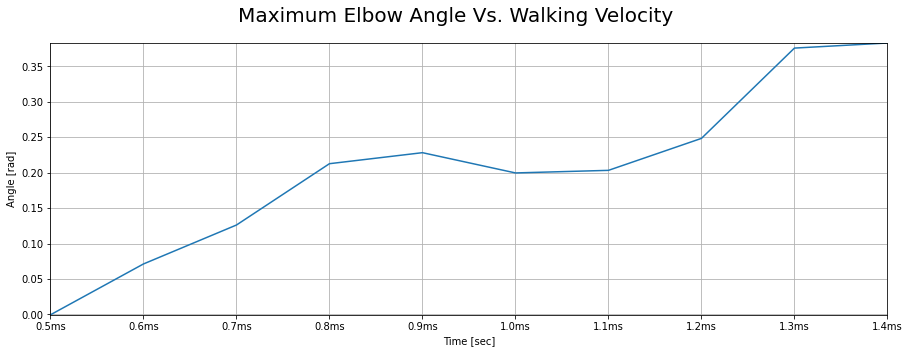

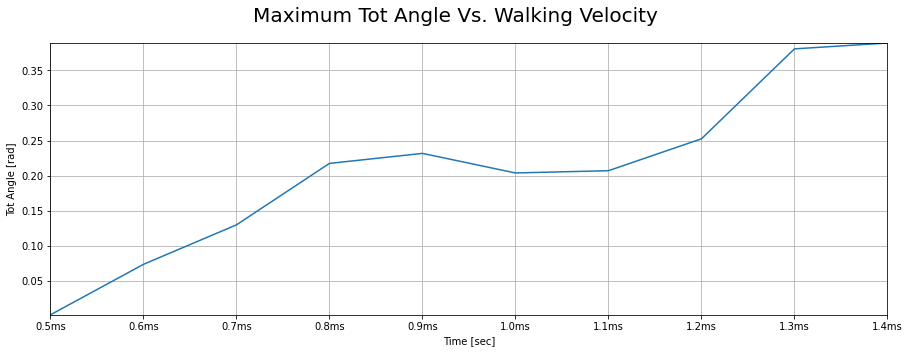

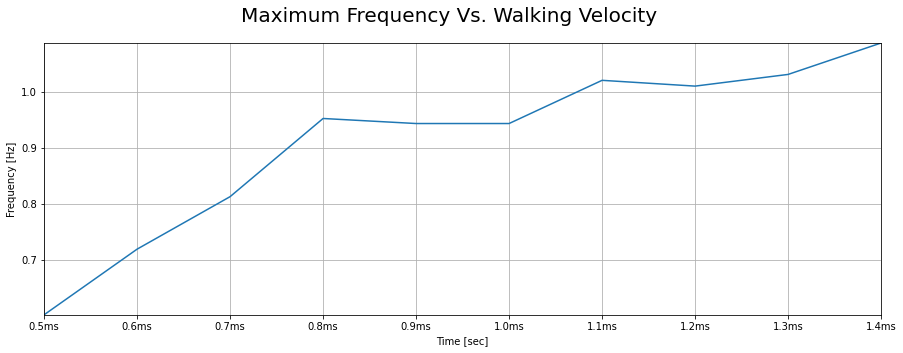

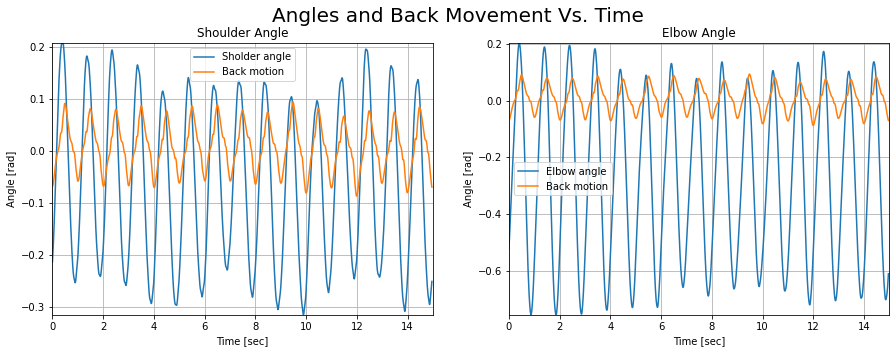

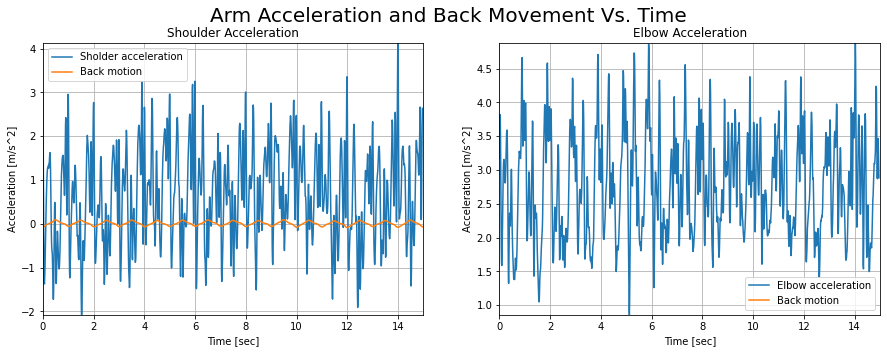

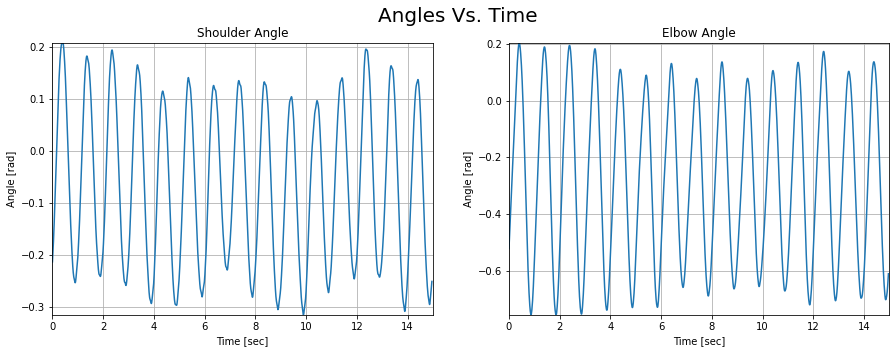

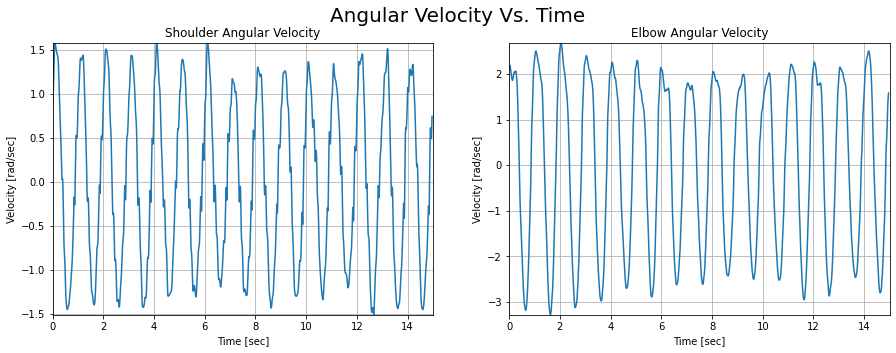

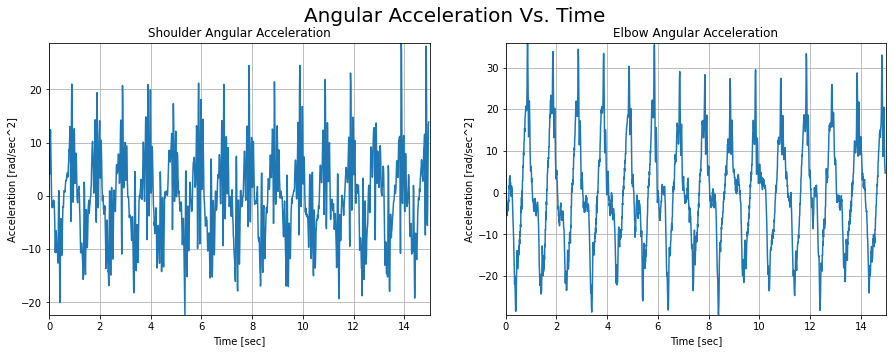

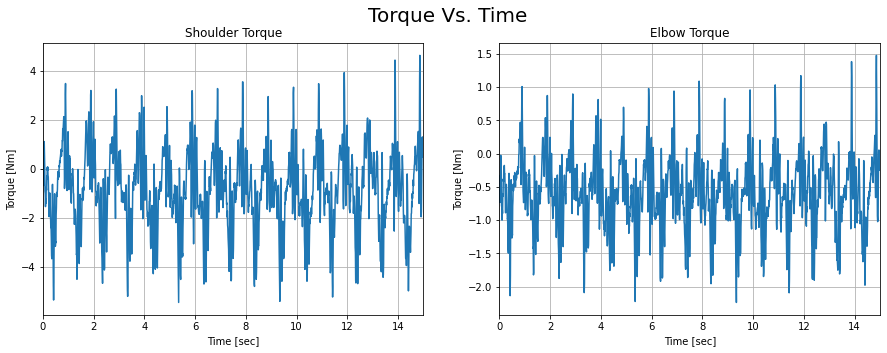

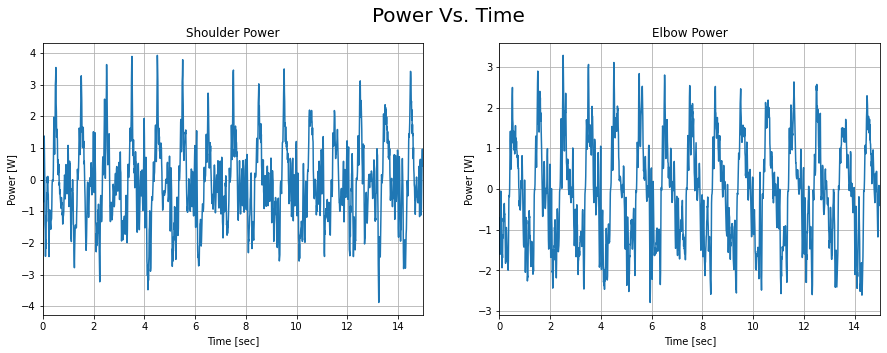

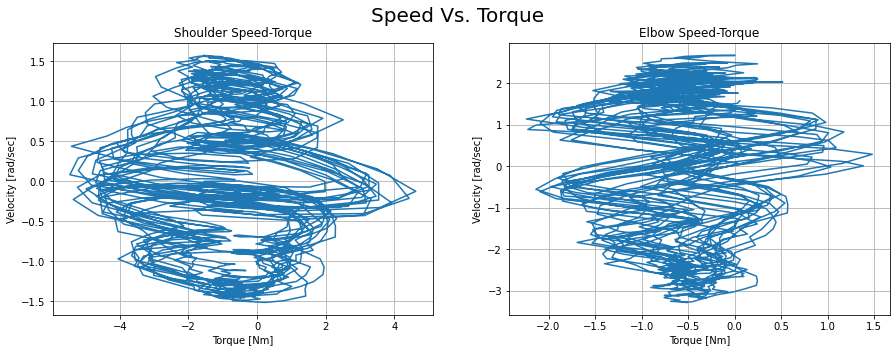

In [126]:
if use_double_pendulum:
    index = 6
    t_list = time_list[index]
    theta1_list = shoulder_ang_list[index]
    theta2_list = elbow_ang_list[index]
    dtheta1_list = shoulder_vel_list[index]
    dtheta2_list = elbow_vel_list[index]
    ddtheta1_list = shoulder_acc_list[index]
    ddtheta2_list = elbow_acc_list[index]
    tau1_list = shoulder_tau_list[index]
    tau2_list = elbow_tau_list[index]
    current1_list = shoulder_current_list[index]
    current2_list = elbow_current_list[index]
    power1_list = shoulder_power_list[index]
    power2_list = elbow_power_list[index]

    back_rotation_list = back_ang_list[index]
    back_position_list = back_pos_list[index]
    back_velocity_list = back_vel_list[index]

    shoulder_acceleration_list = shoulder_acc_data_list[index]
    elbow_acceleration_list = elbow_acc_data_list[index]

    # Compute the trajectory of the arm's motion
    N = int((max(t_list) - min(t_list))/(1/frame_frequency))
    tvec = np.linspace(min(t_list), max(t_list), N)
    traj = np.zeros((6, N))
    back_traj = np.zeros((3, N))
    acc_traj = np.zeros((2, N))
    partial_traj = np.zeros((6, N))

    for i in range(N):
        traj[0, i] = theta1_list[i]
        traj[1, i] = theta2_list[i]
        traj[2, i] = dtheta1_list[i]
        traj[3, i] = dtheta2_list[i]
        traj[4, i] = ddtheta1_list[i]
        traj[5, i] = ddtheta2_list[i]

        back_traj[0, i] = back_rotation_list[i]
        back_traj[1, i] = back_position_list[i]
        back_traj[2, i] = back_velocity_list[i]

        acc_traj[0, i] = shoulder_acceleration_list[i]
        acc_traj[1, i] = elbow_acceleration_list[i]

    for i in range(100):
        partial_traj[0, i] = theta1_list[i]
        partial_traj[1, i] = theta2_list[i]
        partial_traj[2, i] = dtheta1_list[i]
        partial_traj[3, i] = dtheta2_list[i]
        partial_traj[4, i] = ddtheta1_list[i]
        partial_traj[5, i] = ddtheta2_list[i]

    # Calculate the length difference between the time list and the trajectory lists
    diff = (len(t_list) - len(traj[0]))

    # Plot the trajectory lists (angles, velocities, accelerations, torques, and power)
    plt.figure(figsize=(15,5))
    plt.suptitle('Maximum Elbow Angle Vs. Walking Velocity', fontsize=20)
    plt.plot(walking_vel_list[:-1], max_elbow_ang_list[:-1])
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([walking_vel_list[0], walking_vel_list[-2]])
    plt.ylim([min(max_elbow_ang_list), max(max_elbow_ang_list)])
    plt.grid()

    plt.figure(figsize=(15,5))
    plt.suptitle('Maximum Tot Angle Vs. Walking Velocity', fontsize=20)
    plt.plot(walking_vel_list[:-1], max_tot_ang_list[:-1])
    plt.ylabel('Tot Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([walking_vel_list[0], walking_vel_list[-2]])
    plt.ylim([min(max_tot_ang_list), max(max_tot_ang_list)])
    plt.grid()

    plt.figure(figsize=(15,5))
    plt.suptitle('Maximum Frequency Vs. Walking Velocity', fontsize=20)
    plt.plot(walking_vel_list[:-1], freq_list[:-1])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.xlim([walking_vel_list[0], walking_vel_list[-2]])
    plt.ylim([min(freq_list), max(freq_list)])
    plt.grid()
    
    plt.figure(figsize=(15,5))
    plt.suptitle('Angles and Back Movement Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list[:-diff], traj[0], label="Shoulder angle")
    plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[0]), max(traj[0])])
    plt.grid()
    plt.legend()
    plt.title('Shoulder Angle')

    plt.subplot(122)
    plt.plot(t_list[:-diff], traj[1], label="Elbow angle")
    plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[1]), max(traj[1])])
    plt.grid()
    plt.legend()
    plt.title('Elbow Angle')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Arm Acceleration and Back Movement Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list[:-diff], acc_traj[0], label="Shoulder acceleration")
    plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    plt.ylabel('Acceleration [m/s^2]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(acc_traj[0]), max(acc_traj[0])])
    plt.grid()
    plt.legend()
    plt.title('Shoulder Acceleration')

    plt.subplot(122)
    plt.plot(t_list[:-diff], acc_traj[1], label="Elbow acceleration")
    plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    plt.ylabel('Acceleration [m/s^2]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(acc_traj[1]), max(acc_traj[1])])
    plt.grid()
    plt.legend()
    plt.title('Elbow Acceleration')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angles Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list[:-diff], traj[0])
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[0]), max(traj[0])])
    plt.grid()
    plt.title('Shoulder Angle')

    plt.subplot(122)
    plt.plot(t_list[:-diff], traj[1])
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[1]), max(traj[1])])
    plt.grid()
    plt.title('Elbow Angle')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angular Velocity Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list[:-diff], traj[2])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[2]), max(traj[2])])
    plt.grid()
    plt.title('Shoulder Angular Velocity')

    plt.subplot(122)
    plt.plot(t_list[:-diff], traj[3])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[3]), max(traj[3])])
    plt.grid()
    plt.title('Elbow Angular Velocity')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angular Acceleration Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list[:-diff], traj[4])
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[4]), max(traj[4])])
    plt.ylabel('Acceleration [rad/sec^2]')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.title('Shoulder Angular Acceleration')

    plt.subplot(122)
    plt.plot(t_list[:-diff], traj[5])
    plt.ylabel('Acceleration [rad/sec^2]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.ylim([min(traj[5]), max(traj[5])])
    plt.grid()
    plt.title('Elbow Angular Acceleration')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Torque Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list, tau1_list)
    plt.ylabel('Torque [Nm]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Shoulder Torque')

    plt.subplot(122)
    plt.plot(t_list, tau2_list)
    plt.ylabel('Torque [Nm]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Torque')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Power Vs. Time', fontsize=20)
    plt.subplot(121)
    plt.plot(t_list, power1_list)
    plt.ylabel('Power [W]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Shoulder Power')

    plt.subplot(122)
    plt.plot(t_list, power2_list)
    plt.ylabel('Power [W]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Power')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Speed Vs. Torque', fontsize=20)
    plt.subplot(121)
    plt.plot(tau1_list[:-diff], traj[2])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Torque [Nm]')
    plt.grid()
    plt.title('Shoulder Speed-Torque')

    plt.subplot(122)
    plt.plot(tau2_list[:-diff], traj[3])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Torque [Nm]')
    plt.grid()
    plt.title('Elbow Speed-Torque')
    plt.show()

Animating the simulation:

In [ ]:
def animate_double_pend(traj, L1, L2, L1_c, L2_c, T):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
        traj:        trajectory of theta1 and theta2
        L1:          length of the upper arm
        L2:          length of the lower arm 
        L1_c:        length of the center of mass of the upper arm from the shoulder 
        L2_c:        length of the center of mass of the lower arm from the elbow
        T:           length/seconds of animation duration
        
    Returns: None
    """

    # Browser configuration
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    # Getting data from pendulum angle trajectories
    xx1 = L1 * np.sin(traj[0])
    yy1 = -L1 * np.cos(traj[0])
    xx1_c = L1_c * np.sin(traj[0])
    yy1_c = -L1_c * np.cos(traj[0])
    xx2 = xx1 + L2 * np.sin(traj[0] + traj[1])
    yy2 = yy1 - L2 * np.cos(traj[0] + traj[1])
    xx2_c = xx1 + L2_c * np.sin(traj[0] + traj[1])
    yy2_c = yy1 - L2_c * np.cos(traj[0] + traj[1])
    N = len(traj[0])

    # Using these to specify axis limits
    xm = np.min(xx1)
    xM = np.max(xx1)
    ym = np.min(yy1) - 0.6
    yM = np.max(yy1) + 0.6

    # Defining data dictionary
    data = [dict(x=xx1, y=yy1, 
                 mode='lines', name='Arm', 
                 line=dict(width=5, color='blue')
                ),
            dict(x=xx1_c, y=yy1_c, 
                 mode='lines', name='Upper Arm Center of Mass',
                 line=dict(width=2, color='green')
                ),
            dict(x=xx2_c, y=yy2_c, 
                 mode='lines', name='Lower Arm Center of Mass',
                 line=dict(width=2, color='orange')
                ),
            dict(x=xx1, y=yy1, 
                 mode='markers', name='Elbow Trajectory', 
                 marker=dict(color="green", size=2)
                ),
            dict(x=xx2, y=yy2, 
                 mode='markers', name='Hand Trajectory', 
                 marker=dict(color="orange", size=2)
                )
          ]

    # Preparing simulation layout
    layout = dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                  yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                  title='Simulation of Arm Modeled as a Double Pendulum', 
                  hovermode='closest',
                  updatemenus= [{'type': 'buttons',
                                 'buttons': [{'label': 'Play', 'method': 'animate',
                                              'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                             {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                              'transition': {'duration': 0}}],'label': 'Pause', 'method': 'animate'}
                                            ]
                                }]
                 )

    # Defining the frames of the simulation
    frames = [dict(data=[dict(x=[0,xx1[k],xx2[k]], 
                              y=[0,yy1[k],yy2[k]], 
                              mode='lines',
                              line=dict(color='red', width=4)),
                         go.Scatter(
                              x=[xx1_c[k]],
                              y=[yy1_c[k]],
                              mode="markers",
                              marker=dict(color="blue", size=12)),
                         go.Scatter(
                              x=[xx2_c[k]],
                              y=[yy2_c[k]],
                              mode="markers",
                              marker=dict(color="purple", size=12)),
                        ]) for k in range(N)]

    # Putting it all together and plotting
    figure = dict(data=data, layout=layout, frames=frames)           
    iplot(figure)

# Animate the system
L1 = L_u
L2 = L_l
L1_c = L_u_c
L2_c = L_l_c
T = 5

if use_double_pendulum:
    animate_double_pend(partial_traj, L1, L2, L1_c, L2_c, T)